In [5]:
#!/bin/python
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import pickle
import xgboost as xgb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, accuracy_score


from xgboost import XGBClassifier

# argument parsing 
#parser = argparse.ArgumentParser(description='Process some integers.')
#parser.add_argument('integers', metavar='N', type=int, nargs='+',
#                   help='an integer for the accumulator')
#parser.add_argument('--sum', dest='accumulate', action='store_const',
#                   const=sum, default=max,
#                   help='sum the integers (default: find the max)')

#args = parser.parse_args()
#idx_lr = sys.argv[1]
idx_lr = 1
#idx_md = sys.argv[2]
idx_md = 1

# set seed 
rng = np.random.RandomState(1)

# set directory
os.getcwd()
os.chdir("/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/data")



In [12]:
X_data = pd.read_table("X_matrix_exp275.txt", sep = "\t")
ddi_data = pd.read_table("ddi_matrix_exp275.txt", sep = "\t")

In [13]:
X_data.shape

(11652, 550)

In [14]:
ddi_data.shape

(11652, 3)

In [15]:
ddi_data.head()

,V1,V2,V3
0,977,717,0
1,977,957,0
2,1060,766,0
3,367,977,0
4,331,1261,0


In [17]:
# list of desired DDI Types
desired_DDI = [0, # safe
               #4, # The metabolism of #Drug2 can be increased when combined with #Drug1.
               #6, # Drug1 may increase the anticoagulant activities of #Drug2.
               15, # Drug1 may increase the cardiotoxic activities of #Drug2.
               16, # Drug1 may increase the central nervous system depressant (CNS depressant) activities of #Drug2.
               18, # Drug1 can cause an increase in the absorption of #Drug2 resulting in an increased serum concentration and potentially a worsening of adverse effects.
               20, # Drug1 may increase the QTc-prolonging activities of #Drug2.
               32, # Drug1 may increase the sedative activities of #Drug2.
               54, # Drug1 may increase the bradycardic activities of #Drug2.
               72, # Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.
               76, # Drug1 may decrease the sedative activities of #Drug2.
               80  # Drug1 may increase the hepatotoxic activities of #Drug2.
              ]


# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }


y_data = np.array(ddi_data.V3)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data, y_data, test_size = 0.3
#                                                                           , random_state = 1)
#X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_test, y_test, test_size = 0.5
#                                                                       , random_state = 1)



In [19]:
X_data.iloc[1:2, :]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V541,V542,V543,V544,V545,V546,V547,V548,V549,V550
1,0.150883,0.952876,-0.583164,-0.309756,0.13278,0.374803,0.643588,0.061377,0.324082,0.555851,...,0.069416,-0.343783,0.101209,-0.158542,-0.806118,0.180466,0.113574,-0.258039,0.820491,-0.122553


In [21]:
# dmatrix
dtrain = xgb.DMatrix(X_data, label = y_data)
#dtest = xgb.DMatrix(X_test, label = y_test)
#dval = xgb.DMatrix(X_val, label = y_val)

In [25]:
# param
max_depth = parameters["max_depth"][0]
learning_rate = parameters["learning_rate"][0]

param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    'verbosity': 2,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 10}  # the number of classes that exist in this datset
num_round = 50 # the number of training iterations

# training
history_dict = xgb.cv(param, 
                dtrain, 
                num_round,
                nfold = 5,
                seed =0,
                early_stopping_rounds = 5,
                #evals = [(dtest,'test'), (dtrain,'train')],
                #evals_result = history_dict
                )




[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[06:07:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[06:07:21] INFO: /workspace/src/tree/update

In [27]:
# param
max_depth = parameters["max_depth"][0]
learning_rate = parameters["learning_rate"][0]

param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    #'verbosity': 2,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 10}  # the number of classes that exist in this datset
num_round = 100 # the number of training iterations

# training
history_dict = xgb.cv(param, 
                dtrain, 
                num_round,
                nfold = 3,
                seed =0,
                early_stopping_rounds = 5,
                #evals = [(dtest,'test'), (dtrain,'train')],
                #evals_result = history_dict
                )



[06:21:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[06:21:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:21:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:21:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:21:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:21:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[06:21:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[06:21:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[06:21:55] INFO: /workspace/src/tree/update

KeyboardInterrupt: 

[06:22:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[06:22:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[06:22:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:22:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:22:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:22:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:22:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[06:22:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[06:22:07] INFO: /workspace/src/tree/updater

In [28]:
history_dict

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.238543,0.007432,2.276053,0.000297,0.245795,0.005812,2.276306,0.000356
1,0.237727,0.005380,2.250531,0.000582,0.244507,0.003996,2.251015,0.000703
2,0.241718,0.008354,2.225788,0.000880,0.250515,0.007829,2.226505,0.001000
3,0.239487,0.008687,2.201719,0.000984,0.247940,0.006975,2.202690,0.001118
4,0.240388,0.009270,2.178564,0.001203,0.248284,0.007710,2.179792,0.001329
...,...,...,...,...,...,...,...,...
95,0.127403,0.003897,1.122282,0.001277,0.140663,0.003501,1.135880,0.005504
96,0.126888,0.004253,1.115937,0.001220,0.139633,0.004315,1.129616,0.005594
97,0.125558,0.004127,1.109491,0.001225,0.139289,0.004293,1.123199,0.005605
98,0.124914,0.004437,1.103203,0.001002,0.138603,0.004569,1.117035,0.005797


In [26]:
history_dict

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.243284,0.004038,2.276170,0.000146,0.248199,0.006977,2.276442,0.000238
1,0.243520,0.005324,2.250690,0.000318,0.250001,0.007980,2.251249,0.000461
2,0.246374,0.005365,2.225941,0.000473,0.253177,0.009528,2.226742,0.000933
3,0.246395,0.006175,2.201989,0.000559,0.253262,0.006860,2.203014,0.001123
4,0.246932,0.006862,2.178741,0.000669,0.253606,0.008578,2.180028,0.001435
5,0.245666,0.006252,2.156105,0.000846,0.252404,0.007649,2.157561,0.001635
6,0.243091,0.007421,2.134152,0.000946,0.250086,0.007605,2.135888,0.001745
7,0.242383,0.005299,2.112838,0.000907,0.249743,0.005263,2.114822,0.001698
8,0.240431,0.004763,2.091980,0.000930,0.247941,0.006159,2.094194,0.001726
9,0.240495,0.004972,2.071750,0.001018,0.248714,0.004569,2.074119,0.001808


In [24]:
history_dict

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.243284,0.004038,2.276170,0.000146,0.248199,0.006977,2.276442,0.000238
1,0.243520,0.005324,2.250690,0.000318,0.250001,0.007980,2.251249,0.000461
2,0.246374,0.005365,2.225941,0.000473,0.253177,0.009528,2.226742,0.000933
3,0.246395,0.006175,2.201989,0.000559,0.253262,0.006860,2.203014,0.001123
4,0.246932,0.006862,2.178741,0.000669,0.253606,0.008578,2.180028,0.001435
5,0.245666,0.006252,2.156105,0.000846,0.252404,0.007649,2.157561,0.001635
6,0.243091,0.007421,2.134152,0.000946,0.250086,0.007605,2.135888,0.001745
7,0.242383,0.005299,2.112838,0.000907,0.249743,0.005263,2.114822,0.001698
8,0.240431,0.004763,2.091980,0.000930,0.247941,0.006159,2.094194,0.001726
9,0.240495,0.004972,2.071750,0.001018,0.248714,0.004569,2.074119,0.001808


In [38]:
# param
max_depth = parameters["max_depth"][0]
learning_rate = parameters["learning_rate"][0]

param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    'silent': False,  # logging mode - quiet
    'verbosity': 1,  # debug mode
    #'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 10}  # the number of classes that exist in this datset
num_round = 200 # the number of training iterations

# training
history_dict = xgb.cv(param, 
                dtrain, 
                num_round,
                nfold = 5,
                seed =0,
                early_stopping_rounds = 5,
                #evals = [(dtest,'test'), (dtrain,'train')],
                #evals_result = history_dict，
                verbose_eval=1
                )



[0]	train-merror:0.24328+0.00404	train-mlogloss:2.27617+0.00015	test-merror:0.24820+0.00698	test-mlogloss:2.27644+0.00024
[1]	train-merror:0.24352+0.00532	train-mlogloss:2.25069+0.00032	test-merror:0.25000+0.00798	test-mlogloss:2.25125+0.00046
[2]	train-merror:0.24637+0.00537	train-mlogloss:2.22594+0.00047	test-merror:0.25318+0.00953	test-mlogloss:2.22674+0.00093
[3]	train-merror:0.24640+0.00618	train-mlogloss:2.20199+0.00056	test-merror:0.25326+0.00686	test-mlogloss:2.20301+0.00112
[4]	train-merror:0.24693+0.00686	train-mlogloss:2.17874+0.00067	test-merror:0.25361+0.00858	test-mlogloss:2.18003+0.00144
[5]	train-merror:0.24567+0.00625	train-mlogloss:2.15611+0.00085	test-merror:0.25240+0.00765	test-mlogloss:2.15756+0.00164
[6]	train-merror:0.24309+0.00742	train-mlogloss:2.13415+0.00095	test-merror:0.25009+0.00760	test-mlogloss:2.13589+0.00174
[7]	train-merror:0.24238+0.00530	train-mlogloss:2.11284+0.00091	test-merror:0.24974+0.00526	test-mlogloss:2.11482+0.00170
[8]	train-merror:0.24043

In [57]:
ddi_data.shape

(11652, 3)

In [40]:
import pickle
file_Name = "community_ddi.pickle"
# open the file for writing
fileObject = open(file_Name, 'rb')
res_communities = pickle.load(fileObject)
fileObject.close()

In [47]:
ddi_data['V2']

0         717
1         957
2         766
3         977
4        1261
         ... 
11647     624
11648     811
11649     316
11650     227
11651     316
Name: V2, Length: 11652, dtype: int64

In [49]:
test_idx = ddi_data['V1'].isin(res_communities[2]) | ddi_data['V2'].isin(res_communities[2]) 
ddi_df_test = ddi_data[test_idx]
ddi_df_train = ddi_data[~test_idx]



In [50]:
y_data = np.array(ddi_data['V3'])

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

X_train = X_data[~test_idx]
X_test = X_data[test_idx]
y_train = y_data[~test_idx]
y_test = y_data[test_idx]
X_train.shape

(10991, 550)

(array([5815.,    0., 4213.,    0.,  265.,    0.,  492.,    0.,    0.,
         206.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <a list of 10 Patch objects>)

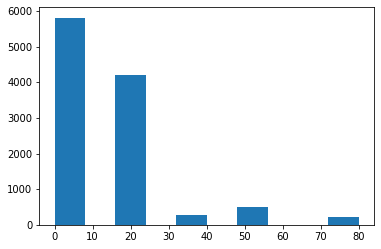

In [53]:
plt.hist(ddi_df_train['V3'])

(array([ 20., 103.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 538.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <a list of 10 Patch objects>)

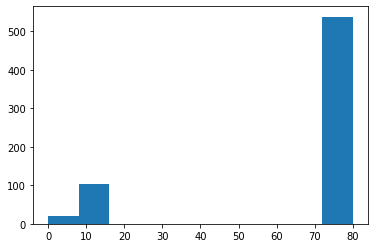

In [52]:
plt.hist(ddi_df_test['V3'])

In [ ]:
# community 

In [54]:
dtrain = xgb.DMatrix(X_data, label = y_data)
dtest = xgb.DMatrix(X_test, label = y_test)
#dval = xgb.DMatrix(X_val, label = y_val)

print("----- INFO: training data preprocess is done. -----")
# param
max_depth = parameters["max_depth"][idx_md]
learning_rate = parameters["learning_rate"][idx_lr]


param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    #'verbosity': 3,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 10}  # the number of classes that exist in this datset
num_round = 20 # the number of training iterations

print("----- INFO: XGBoost Parameters -----")
print(param)

# training
history_dict = {}
bst = xgb.train(param, 
                dtrain, 
                num_round,
                early_stopping_rounds = 5,
                evals = [(dtrain,'train'), (dtest,'test')],
                evals_result = history_dict,
                verbose_eval=1
               )




----- INFO: training data preprocess is done. -----
----- INFO: XGBoost Parameters -----
{'max_depth': 4, 'learning_rate': 0.1, 'eta': 0.3, 'objective': 'multi:softprob', 'eval_metric': ['merror', 'mlogloss'], 'num_class': 10}
[0]	train-merror:0.21619	train-mlogloss:2.00679	test-merror:0.16339	test-mlogloss:1.91901
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 5 rounds.
[1]	train-merror:0.15920	train-mlogloss:1.79075	test-merror:0.16339	test-mlogloss:1.67744
[2]	train-merror:0.12951	train-mlogloss:1.62121	test-merror:0.11346	test-mlogloss:1.47521
[3]	train-merror:0.11328	train-mlogloss:1.47426	test-merror:0.08926	test-mlogloss:1.30845
[4]	train-merror:0.10316	train-mlogloss:1.35817	test-merror:0.06959	test-mlogloss:1.18065
[5]	train-merror:0.09294	train-mlogloss:1.24955	test-merror:0.06959	test-mlogloss:1.06130
[6]	train-merror:0.08702	train-mlogloss:1.15549	test-merror:0.06959	test-mlogloss:0

In [55]:
history_dict

{'train': {'merror': [0.216186,
   0.1592,
   0.129506,
   0.113285,
   0.103158,
   0.092945,
   0.087024,
   0.084106,
   0.077068,
   0.069859,
   0.065139,
   0.062393,
   0.061191,
   0.058702,
   0.055699,
   0.053467,
   0.051407,
   0.049262,
   0.048833,
   0.045915],
  'mlogloss': [2.006786,
   1.790748,
   1.621207,
   1.474265,
   1.358168,
   1.249548,
   1.155487,
   1.07647,
   1.00054,
   0.929544,
   0.869076,
   0.815165,
   0.766566,
   0.721475,
   0.678698,
   0.639759,
   0.60545,
   0.572378,
   0.542424,
   0.512817]},
 'test': {'merror': [0.163389,
   0.163389,
   0.113464,
   0.089259,
   0.069592,
   0.069592,
   0.069592,
   0.066566,
   0.057489,
   0.040847,
   0.02118,
   0.007564,
   0.006051,
   0.006051,
   0.006051,
   0.006051,
   0.006051,
   0.006051,
   0.006051,
   0.004539],
  'mlogloss': [1.919009,
   1.67744,
   1.475207,
   1.308454,
   1.18065,
   1.0613,
   0.967757,
   0.871288,
   0.784018,
   0.715498,
   0.654101,
   0.599899,
   0.5488

In [59]:
bst

In [60]:
import pickle

file_Name = "10class_xgboost_model_expression.pickle"
# open the file for writing
fileObject = open(file_Name,'wb')

# this writes the object a to the
# file named 'testfile'
pickle.dump(bst,fileObject)

# here we close the fileObject
fileObject.close()
# we open the file for reading
fileObject = open(file_Name,'rb')
# load the object from the file into var b
b = pickle.load(fileObject)

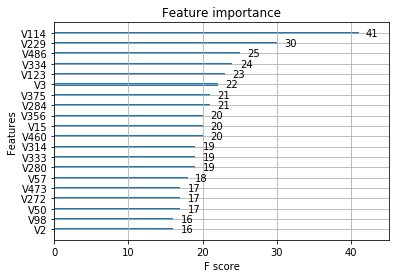

In [61]:
from xgboost import plot_importance
plot_importance(bst, max_num_features=20) # top 10 most important features
plt.show()



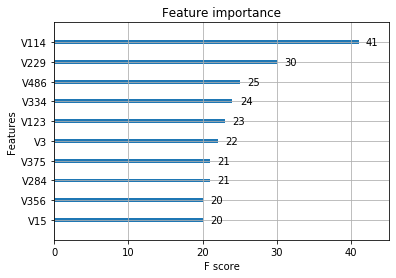

In [62]:
from xgboost import plot_importance
plot_importance(bst, max_num_features=10) # top 10 most important features
plt.show()

(array([  7.,  70., 127., 150., 117.,  55.,  20.,   2.,   1.,   1.]),
 array([-1.16792887, -0.83374905, -0.49956922, -0.16538939,  0.16879044,
         0.50297026,  0.83715009,  1.17132992,  1.50550975,  1.83968957,
         2.1738694 ]),
 <a list of 10 Patch objects>)

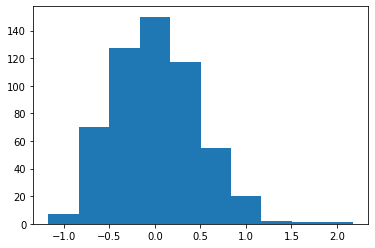

In [20]:
plt.hist(X_data.iloc[1,:])

In [5]:



# testing
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

# save the object 
print("----- INFO: saving results -----")
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/cv_output/"
history_path = output_dir + "_lr_" + learning_rate + "_md_" + max_depth + "_history_dict.pickle"
model_path = output_dir + "_lr_" + learning_rate + "_md_" + max_depth + "_xgb.pickle"
pickle.dump(history_dict, history_path)
pickle.dump(bst, model_path)



TypeError: cv() got an unexpected keyword argument 'evals'

In [19]:



# testing
#preds = bst.predict(dtest)
#best_preds = np.asarray([np.argmax(line) for line in preds])
#preds = bst.predict(dtest)
#best_preds = np.asarray([np.argmax(line) for line in preds])

# save the object 
print("----- INFO: saving results -----")
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output/"
history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
model_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_xgb.pickle"
history_fo = open(history_path, "wb")
model_fo = open(model_path, "wb")
pickle.dump(history_dict, history_fo)
pickle.dump(bst, model_fo)
history_fo.close()
model_fo.close()


[19:39:33] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[19:39:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:39:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:39:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:39:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[19:40:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:40:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:40:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[19:40:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra node

In [ ]:
# collect the results

### networkx 

In [23]:
import networkx as nx

In [10]:
networkx.__version__

'2.3'

In [11]:
ddi_clean.shape

(27675, 3)

In [14]:
type(ddi_clean)

pandas.core.frame.DataFrame

In [17]:
drug_list = np.unique(pd.concat([ddi_clean.drug1, ddi_clean.drug2]))

In [21]:
len(drug_list)
drug_list[:6]

array([ 14,  35,  91, 104, 121, 126])

##### building the graph 

In [24]:
G = nx.Graph()
G.add_nodes_from(drug_list)

In [27]:
ddi_clean.head()

,drug1,drug2,Label
0,956,316,0
1,977,717,0
2,977,957,0
3,1060,766,0
4,1395,977,0


In [30]:
ddi_clean[ddi_clean.drug2 == 977]

,drug1,drug2,Label
4,1395,977,0
5,367,977,0
8,304,977,0
10,294,977,0
153983,2659,977,72


In [41]:
drug_pair_list = list(zip(list(ddi_clean.drug1), list(ddi_clean.drug2)))

In [42]:
G.add_edges_from(drug_pair_list)

In [44]:
print(G.number_of_nodes())
print(G.number_of_edges())

1115
27675


In [49]:
nx.draw_shell()

Object `nx.draw_shell()` not found.


In [52]:
np.unique(list(drug_pair_list[0]))

array([316, 956])

In [53]:
from networkx.algorithms.community import greedy_modularity_communities

In [54]:
res_communities = greedy_modularity_communities(G)


In [55]:
c = list(res_communities)

In [57]:
len(res_communities)

9

In [59]:
!pwd

/gpfs/loomis/pi/zhao2/zy92/projects/ddipred/ddi_pred/data


In [60]:
from matplotlib import pylab

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph.pdf")

/home/zy92/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


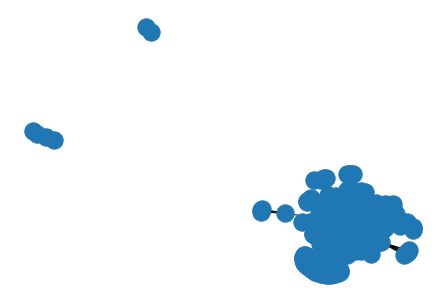

In [62]:
nx.draw(G)

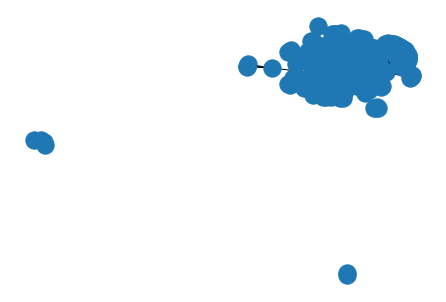

In [63]:
nx.draw(G,pos=nx.spring_layout(G))

/home/zy92/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


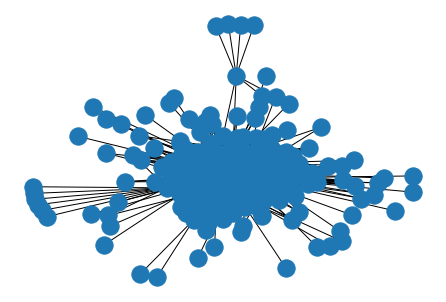

In [65]:
G1 = G.subgraph(res_communities[0])
nx.draw(G1,pos=nx.spring_layout(G1))

In [69]:
a = [1,3] + [4,6]
a

[1, 3, 4, 6]

In [72]:
type(res_communities[1])

frozenset

In [73]:
type(res_communities)

list

In [74]:
len(list(res_communities[1]) + list(res_communities[2]))

485

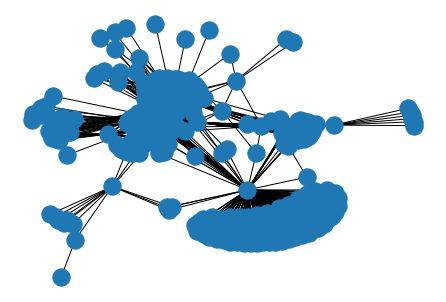

In [76]:
G2 = G.subgraph(list(res_communities[1]) + list(res_communities[2]) + list(res_communities[3]))
nx.draw(G2,pos=nx.spring_layout(G2))

In [77]:
pos = nx.spring_layout(G) # positions for all nodes

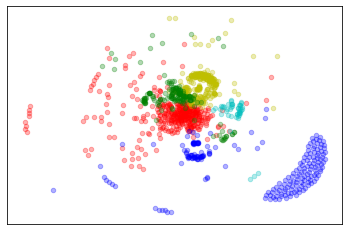

In [96]:
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[0],
                       node_color='r',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[1],
                       node_color='y',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[2],
                       node_color='b',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[3],
                       node_color='g',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[4],
                       node_color='c',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(res_communities[5]),
                       node_color='r',
                       node_size=20,
                   alpha=0.3)
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=list(res_communities[6]),
#                        node_color='r',
#                        node_size=20,
#                    alpha=0.3)
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=list(res_communities[7]),
#                        node_color='r',
#                        node_size=20,
#                    alpha=0.3)
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=list(res_communities[8]),
#                        node_color='r',
#                        node_size=20,
#                    alpha=0.3)


In [84]:
[len(x) for x in res_communities]

[393, 263, 222, 171, 48, 8, 4, 4, 2]

In [ ]:
res_communities[1]

In [100]:
test_idx = ddi_clean.drug1.isin(res_communities[1]) | ddi_clean.drug2.isin(res_communities[1]) 
ddi_df_test = ddi_clean[test_idx]
ddi_df_train = ddi_clean[~test_idx]


In [101]:
ddi_df_test.shape

(11016, 3)

In [102]:
ddi_df_train.shape

(16659, 3)

In [ ]:
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

In [104]:
X_train = X_data[~test_idx]
X_test = X_data[test_idx]
y_train = y_data[~test_idx]
y_test = y_data[test_idx]
X_train.shape

(16659, 4318)

In [108]:
dtrain = xgb.DMatrix(X_data, label = y_data)
dtest = xgb.DMatrix(X_test, label = y_test)
#dval = xgb.DMatrix(X_val, label = y_val)

print("----- INFO: training data preprocess is done. -----")
# param
max_depth = parameters["max_depth"][idx_md]
learning_rate = parameters["learning_rate"][idx_lr]


param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    'verbosity': 3,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 10}  # the number of classes that exist in this datset
num_round = 10 # the number of training iterations

print("----- INFO: XGBoost Parameters -----")
print(param)

----- INFO: training data preprocess is done. -----
----- INFO: XGBoost Parameters -----
{'max_depth': 4, 'learning_rate': 0.1, 'eta': 0.3, 'verbosity': 3, 'objective': 'multi:softprob', 'eval_metric': ['merror', 'mlogloss'], 'num_class': 10}


In [109]:
# training
history_list = xgb.cv(param, 
                dtrain, 
                num_round,
                nfold = 3,
                seed =0,
                early_stopping_rounds = 5,
                #evals = [(dtest,'test'), (dtrain,'train')],
                #evals_result = history_dict
                )



[17:39:23] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[17:39:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[17:39:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:39:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:39:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[17:39:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:39:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[17:39:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[17:39:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nod

In [110]:
history_list


,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.210298,0.005948,2.016191,0.001178,0.217453,0.001457,2.018391,0.001515
1,0.136947,0.000452,1.801880,0.001927,0.146305,0.004451,1.806474,0.001601
2,0.121066,0.003474,1.632245,0.002663,0.131888,0.002112,1.639116,0.001202
3,0.110768,0.003477,1.494462,0.002919,0.121373,0.004776,1.502799,0.001456
4,0.103288,0.000982,1.378172,0.003740,0.113568,0.005499,1.388180,0.002482
5,0.092900,0.002361,1.273003,0.002287,0.102439,0.005892,1.284172,0.004305
6,0.087299,0.001758,1.183210,0.001526,0.096477,0.005716,1.195453,0.004203
7,0.080000,0.003992,1.100019,0.002867,0.089033,0.006313,1.113129,0.007371
8,0.073315,0.002601,1.026729,0.002517,0.082638,0.004788,1.040269,0.006068
9,0.068419,0.002167,0.957578,0.002112,0.078518,0.004053,0.971995,0.005733


In [114]:
print(dtrain.num_row

<bound method DMatrix.num_row of <xgboost.core.DMatrix object at 0x2af7ac987610>>


In [123]:
from sklearn.linear_model import LogisticRegression
#X, y = load_iris(return_X_y=True)
clf = LogisticRegression(multi_class="multinomial", solver='lbfgs').fit(X_data, y_data)
clf.predict(X_data[:2, :])

clf.predict_proba(X_data[:2, :])


clf.score(X_data, y_data)

/home/zy92/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7726106594399277